In [39]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import HGate, CXGate
from qiskit.circuit import Parameter, ParameterVector, Barrier
from qiskit.circuit import Gate
from qiskit_algorithms.minimum_eigensolvers.vqe import VQE
from qiskit.primitives import StatevectorEstimator as Estimator
import numpy as np
from qiskit_algorithms.optimizers import SPSA


from qiskit.qiskit.algorithms.optimizers import SPSA


ModuleNotFoundError: No module named 'qiskit.qiskit'

In [35]:
optimizer = SPSA()

In [36]:
dir(optimizer)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_bounds_support_level',
 '_compute_update',
 '_gradient_support_level',
 '_initial_point_support_level',
 '_max_evals_grouped',
 '_nfev',
 '_options',
 '_point_estimate',
 '_point_sample',
 '_smoothed_hessian',
 'allowed_increase',
 'blocking',
 'bounds_support_level',
 'calibrate',
 'callback',
 'estimate_stddev',
 'get_support_level',
 'gradient_num_diff',
 'gradient_support_level',
 'hessian_delay',
 'initial_hessian',
 'initial_point_support_level',
 'is_bounds_ignored',
 'is_bounds_required',
 'is_bounds_supported',
 'is_gradient_ignored',
 'is_gra

In [28]:
num_q_orbital=4
num_q_site=4

qc_total=QuantumCircuit(num_q_orbital+num_q_site)

qc_orbital=QuantumCircuit(num_q_orbital) # orbital register

qc_site=QuantumCircuit(num_q_site) # site register
qc_p=QuantumCircuit(num_q_site) # minimum unit for representing quantum number p
qc_QFT=QuantumCircuit(num_q_site) # quantum circuit for executing quantum fourier transform

In [48]:
from qiskit.quantum_info import SparsePauliOp

def list_to_str(list_data):
    str_first = ''
    for str_data in list_data:
        str_first += str_data
    return str_first

########### 여기 줄 잘 바꾸샘
def custom_hamiltonian(qubit_number):
    list_data = []
    for i in range(qubit_number):
        raw_data = ['I']*qubit_number
        raw_data[i] = 'Z'
        data = list_to_str(raw_data)
        list_data.append(data)

    
    
    return SparsePauliOp(list_data,coeffs=[0.1*i for i in range(qubit_number)])

In [65]:
def A(theta, phi):
    qc_ansatze_unit=QuantumCircuit(2, name="A") # minimum unit of the number preserving ansatze ; included into the qc_orbital
    qc_ansatze_unit.cx(0,1)
    qc_ansatze_unit.rz(phi+np.pi, 0).inverse()
    qc_ansatze_unit.ry(theta+np.pi/2, 0).inverse()
    qc_ansatze_unit.cx(1,0)
    qc_ansatze_unit.ry(theta+np.pi/2, 0)
    qc_ansatze_unit.rz(phi+np.pi, 0)
    qc_ansatze_unit.cx(0,1)
    return qc_ansatze_unit

def ansatze_orbital_encoding(energy_level):
    qc_ansatze_o_ecdg=QuantumCircuit(num_q_orbital)
    qc_ansatze_o_ecdg.x(energy_level)
    return qc_ansatze_o_ecdg    

def ansatze_level(energy_level, params_level):
    qc_ansatze_E_level=QuantumCircuit(num_q_orbital, name='level_'+str(energy_level))
    for i in range(num_q_orbital-energy_level-1):
        inst=A(theta=params_level[2*i], phi=params_level[2*i+1]).to_instruction()
        qc_ansatze_E_level.append(inst, [i+energy_level, i+energy_level+1])
    return qc_ansatze_E_level




def vqe(energy_level, previous_params_list):
    if previous_params_list==None: # target energy level is 0th : ground state band
        qc_orbital_0th=ansatze_orbital_encoding(energy_level) # orbital encoding for 0th energy level
        
        # addition of 0th level ansatze
        num_params=2*(num_q_orbital-energy_level-1)
        params_0th=ParameterVector("θ", num_params)
        qc_orbital_tmp=ansatze_level(energy_level, params_level=params_0th)
        inst=qc_orbital_tmp.to_instruction()
        qc_orbital_0th.append(inst, range(num_q_orbital))
        def loss(x):
            estimator = Estimator()
            pub = (qc_orbital_0th,custom_hamiltonian(4),x)
            job = estimator.run([pub])
            result = job.result()[0]
            return -np.sum(result.data.evs)

        result = optimizer.minimize(loss,x0 = [0.2]*qc_orbital_0th.num_parameters)
        print(f'1st eigen energy information : {result}')
        params_fixed_0th = result.x # further obtained
        
        return qc_orbital_0th, params_fixed_0th
    else: # set ansatze for nonzero energy level 
        qc_orbital_ith=ansatze_orbital_encoding(energy_level)    
        
        # current energy level
        num_params=2*(num_q_orbital-energy_level-1)
        params=ParameterVector("θ", num_params)
        qc_orbital_tmp=ansatze_level(energy_level, params_level=params)
        inst_current=qc_orbital_tmp.to_instruction()
        qc_orbital_ith.append(inst_current, range(num_q_orbital))
        
        # previous energy level with fixed parameters
        for i in reversed(range(energy_level)):
            qc_orbital_ith.barrier()
            
            params=previous_params_list[i]
            previous_level_qc=ansatze_level(energy_level=i, params_level=params)
            inst=previous_level_qc.to_instruction()
            qc_orbital_ith.append(inst, range(num_q_orbital))
        
        def loss(x):
            estimator = Estimator()
            pub = (qc_orbital_ith,custom_hamiltonian(4),x)
            job = estimator.run([pub])
            result = job.result()[0]
            return -np.sum(result.data.evs)

        result = optimizer.minimize(loss,x0 = [0.2]*qc_orbital_ith.num_parameters)
        print(f'{energy_level+1}th eigen energy information : {result}')
        params_fixed_ith=result.x # further obtained
        
        return qc_orbital_ith, params_fixed_ith


upper_bound_level=2
params_library = dict()
for i in range(upper_bound_level+1):
    if i==0:
        _ , params_fixed_0th = vqe(energy_level=i, previous_params_list=None)
        params_library['level'+str(i)] = params_fixed_0th
    else:
        params_send = [params_library['level'+str(j)] for j in range(i)]
        _ , params_fixed_ith = vqe(energy_level=i, previous_params_list=params_send)
        params_library['level'+str(i)] = params_fixed_ith

1st eigen energy information : {   'fun': np.float64(-0.5999999999956839),
    'jac': None,
    'nfev': 200,
    'nit': 100,
    'njev': None,
    'x': array([ 1.57079609,  7.16875629, -4.7123907 , -0.61390302,  4.71238504,
        0.63024131])}
2th eigen energy information : {   'fun': np.float64(-0.4000000000031024),
    'jac': None,
    'nfev': 200,
    'nit': 100,
    'njev': None,
    'x': array([1.57079633, 5.74338938, 1.57079633, 1.59833948])}
3th eigen energy information : {   'fun': np.float64(-0.2000000000011809),
    'jac': None,
    'nfev': 200,
    'nit': 100,
    'njev': None,
    'x': array([1.57079633, 1.24195059])}


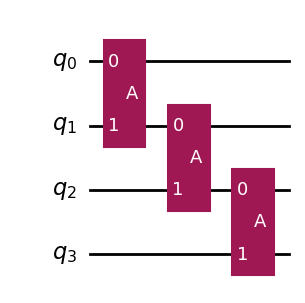

In [5]:
energy_level=0
num_params=2*(num_q_orbital-energy_level-1)

# train and get fixed params params_0_fixed & eigenvalues

params_0_fixed=np.random.rand(num_params).tolist()
qc_orbital_0=ansatze_level(energy_level, params_level=params_0_fixed)
qc_orbital_0.draw("mpl")

In [6]:
energy_level=1
num_params=2*(num_q_orbital-energy_level-1)
params_1=ParameterVector("θ", num_params)
qc_orbital_1=ansatze_level(energy_level, params_level=params_1)
inst_0=qc_orbital_0.to_instruction()
qc_orbital_1.barrier()
qc_orbital_1.append(inst_0, range(num_q_orbital))
qc_orbital_1.draw("mpl")

KeyError: 1813372304848

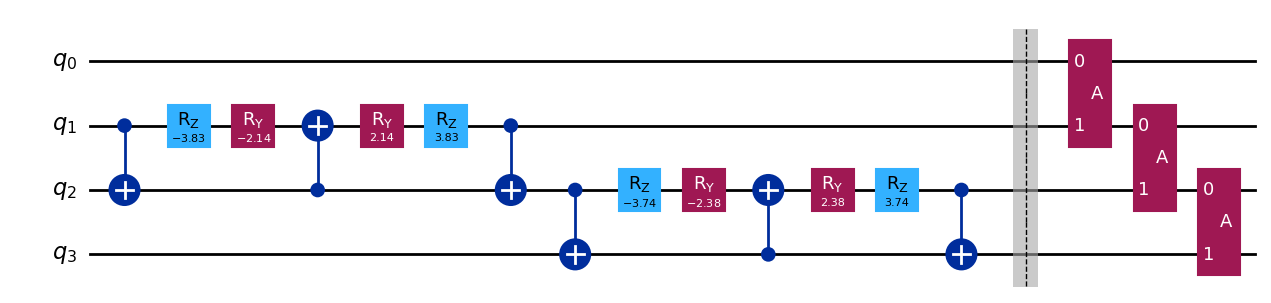

In [71]:
energy_level=1
num_params=2*(num_q_orbital-energy_level-1)

# train and get fixed params params_1_fixed & eigenvalues

params_1_fixed=np.random.rand(num_params).tolist()
qc_orbital_1=ansatze_level(energy_level, params_level=params_0_fixed)
inst_0=qc_orbital_0.to_instruction()
qc_orbital_1.barrier()
qc_orbital_1.append(inst_0, range(num_q_orbital))
qc_orbital_1.draw("mpl")
qc_orbital_1.decompose().draw("mpl")

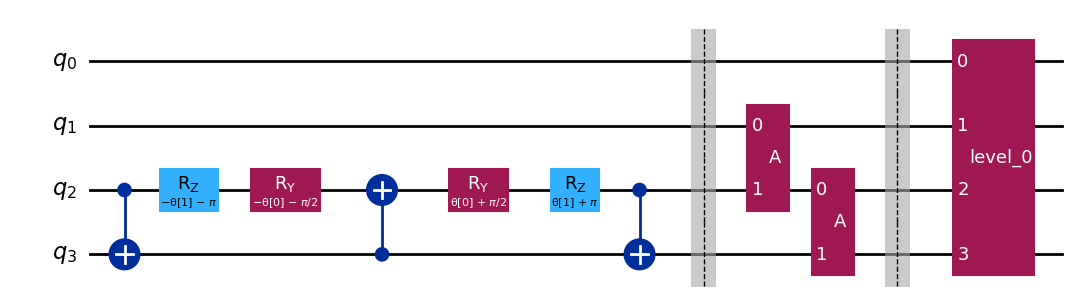

In [72]:
energy_level=2
num_params=2*(num_q_orbital-energy_level-1)
params_2=ParameterVector("θ", num_params)
qc_orbital_2=ansatze_level(energy_level, params_level=params_2)
inst_1=qc_orbital_1.to_instruction()
qc_orbital_2.barrier()
qc_orbital_2.append(inst_1, range(num_q_orbital))
qc_orbital_2.draw("mpl")
qc_orbital_2.decompose().draw("mpl")

In [ ]:
num_params=(num_q_orbital)*(num_q_orbital-1)
params_0=ParameterVector("θ", num_params)


qc_orbital=ansatze_level(energy_level=0, params_level=params)
qc_orbital.draw("mpl")

In [ ]:
print(

In [43]:
def A(theta, phi):
    qc_ansatze_unit=QuantumCircuit(2, name="A") # minimum unit of the number preserving ansatze ; included into the qc_orbital
    qc_ansatze_unit.cx(0,1)
    qc_ansatze_unit.rz(phi+np.pi, 0).inverse()
    qc_ansatze_unit.ry(theta+np.pi/2, 0).inverse()
    qc_ansatze_unit.cx(1,0)
    qc_ansatze_unit.ry(theta+np.pi/2, 0)
    qc_ansatze_unit.rz(phi+np.pi, 0)
    qc_ansatze_unit.cx(0,1)
    return qc_ansatze_unit

def ansatze_level(energy_level, params_level):
    qc_ansatze_E_level=QuantumCircuit(num_q_orbital)
    for i in range(num_q_orbital-energy_level-1):
        inst=A(theta=params_level[2*i], phi=params_level[2*i+1]).to_instruction()
        qc_ansatze_E_level.append(inst, [i+energy_level, i+energy_level+1])
    return qc_ansatze_E_level


qc_total=QuantumCircuit(num_q_orbital+num_q_site)

qc_orbital=QuantumCircuit(num_q_orbital) # orbital register

qc_site=QuantumCircuit(num_q_site) # site register
qc_p=QuantumCircuit(num_q_site) # minimum unit for representing quantum number p
qc_QFT=QuantumCircuit(num_q_site) # quantum circuit for executing quantum fourier transform

In [ ]:
def vqe(energy_level):
    if energy_level==0:
        num_params=2*(num_q_orbital-energy_level-1)
        params_0=ParameterVector("θ", num_params)
        qc_orbital_0=ansatze_level(energy_level, params_level=params_0)
        # train and get fixed params params_0_fixed & eigenvalues
    if energy_level==1:
        num_params=2*(num_q_orbital-energy_level-1)
        params_1=ParameterVector("θ", num_params)
        qc_orbital_1=ansatze_level(energy_level, params_level=params_1)
        inst=qc_orbital_0.to_instruction()
        qc_orbital_1.append(inst, range(num_q_orbital))

In [ ]:
num_params=(num_q_orbital)*(num_q_orbital-1)
params_0=ParameterVector("θ", num_params)


qc_orbital=ansatze_level(energy_level=0, params_level=params)
qc_orbital.draw("mpl")
# qc_orbital.decompose().draw("mpl")

In [37]:
qc_orbital.reset(qubit=range(num_q_orbital))

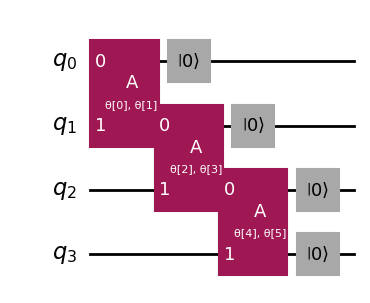

In [39]:
qc_orbital.draw("mpl")

In [ ]:
print(

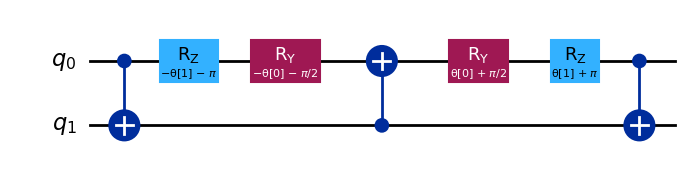

In [22]:
def A(theta, phi):
    qc=QuantumCircuit(2)
    qc.cx(0,1)
    qc.rz(phi+np.pi, 0).inverse()
    qc.ry(theta+np.pi/2, 0).inverse()
    qc.cx(1,0)
    qc.ry(theta+np.pi/2, 0)
    qc.rz(phi+np.pi, 0)
    qc.cx(0,1)
    return qc

params=ParameterVector("θ", 20)

A(theta=params[0], phi=params[1]).draw("mpl")

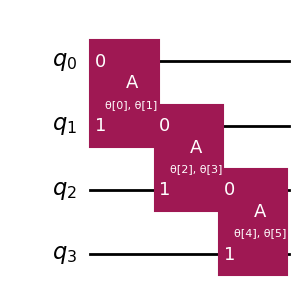

In [33]:
def A(theta, phi):
    qc_ansatze=QuantumCircuit(2, name="A") # minimum unit of the number preserving ansatze ; included into the qc_orbital
    qc_ansatze.cx(0,1)
    qc_ansatze.rz(phi+np.pi, 0).inverse()
    qc_ansatze.ry(theta+np.pi/2, 0).inverse()
    qc_ansatze.cx(1,0)
    qc_ansatze.ry(theta+np.pi/2, 0)
    qc_ansatze.rz(phi+np.pi, 0)
    qc_ansatze.cx(0,1)
    return qc_ansatze

qc_total=QuantumCircuit(num_q_orbital+num_q_site)

qc_orbital=QuantumCircuit(num_q_orbital) # orbital register

qc_site=QuantumCircuit(num_q_site) # site register
qc_p=QuantumCircuit(num_q_site) # minimum unit for representing quantum number p
qc_QFT=QuantumCircuit(num_q_site) # quantum circuit for executing quantum fourier transform

energy_level=0

num_params=(num_q_orbital)*(num_q_orbital-1)
params=ParameterVector("θ", num_params)

# inst_A=A(theta=params[0], phi=params[1]).to_instruction()

for i in range(num_q_orbital-energy_level-1):
    qc_orbital.append(A(theta=params[2*i], phi=params[2*i+1]).to_instruction(), [i+energy_level, i+energy_level+1])
        
qc_orbital.draw("mpl")

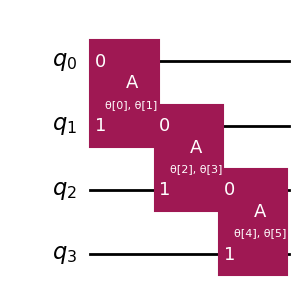

In [25]:
qc_tmp=qc_orbital

qc_tmp.draw("mpl")
qc_orbital.draw("mpl")

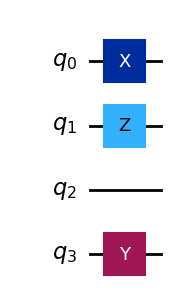

In [6]:
qc_a = QuantumCircuit(4)
qc_a.x(0)
 
qc_b = QuantumCircuit(2, name="qc_b")
qc_b.y(0)
qc_b.z(1)
 
# compose qubits (0, 1) of qc_a to qubits (1, 3) of qc_b respectively
combined = qc_a.compose(qc_b, qubits=[3, 1])
combined.draw("mpl")